In [1]:
import networkx as nx

from ase.io import read, write
from ase.build import bulk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
import pickle
import matplotlib as mpl
mpl.style.use("share/custom.mplstyle")


In [2]:
from share.utilities import flatten
from share.graphs import DefectGraph, read_write_defects

# Generating data

In [3]:
a1M_11Ks_file = 'data/aSi_1Matom_maintext.xyz'

In [4]:
# warning, will need about 4GB of RAM for 1M-atom structure, takes 7 minutes on my machine
graph_1M = DefectGraph(a1M_11Ks_file, es_name="GAP18_energies", medium=[14, 24, 34], bulk_level=3)

Preparing structure files... done. Structure has 613069 atoms
setting types...[0. 0. 0. ... 0. 0. 0.]
[0. 1. 0. ... 0. 1. 0.]
[1. 3. 2. ... 2. 2. 1.]
Type summary:  (array([ 2,  3,  5,  6,  7, 14, 24, 34]), array([    10,   6558,  16809,     99,      1,  88598, 209680, 291314]))
 done
Found connected components:  19121
Found 19121 subgraphs
Medium is  [14, 24, 34]
Searching recursively for neighbouring medium
Linking nodes with max separation  0
found 0 extra links due to non-zero max separation
Length of tmp_Gs 19121
Categorising 19121 subgraphs
Summary: 

[5]                                                    10801
[3]                                                    5945
[5, 5]                                                 702
[5, 5, 5]                                              475
[5, 3]                                                 435
[5, 5, 5, 5]                                           194
[5, 5, 5, 5]                                           95
[5, 5, 5]            

In [5]:
es = read(a1M_11Ks_file).arrays["GAP18_energies"]

In [6]:
a1M_11Ks_g18_es_bulk = np.array([es[i] for i in 
                                 np.setdiff1d(np.arange(len(es)),
                                              graph_1M.at.arrays['id']-1)])

# Cluster bar chart

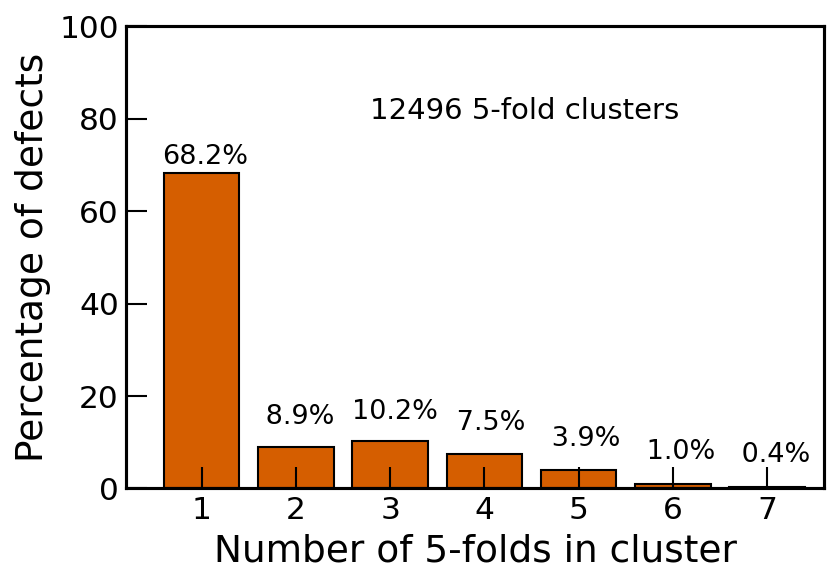

In [7]:
fig, axs = plt.subplots(1,1, figsize=(6, 4), dpi=150)
s = graph_1M
lab = 11

cs = sns.color_palette('colorblind')
h, b = np.histogram(s.clus5, bins=np.arange(1,9))
h = h.astype(np.float64)
total_def = np.sum(s.clus5)
h *= (100*b[:-1]/total_def)  # proportion of total defect number
axs.bar(b[:-1], h, color=cs[3], edgecolor='k')
axs.set(xticks=np.arange(1,9))
for i, val in enumerate(h):
    axs.text(b[i]-0.43+b[i]*0.01, 
             (h[i]*0.95+h[0]*0.08), '{:>4s}'.format(
                 str(np.round(h[i], decimals=1)))+'%', 
                 fontdict={'fontsize':13})

axs.set_ylim(0, 100)
axs.set_xlim(0.2, 7.6)
axs.set(xlabel='Number of 5-folds in cluster')
axs.text(0.35, 0.8, '\n{} 5-fold clusters'.format(len(s.clus5)),
            transform=axs.transAxes, fontsize=14)
    
axs.set(ylabel='Percentage of defects')

fig.set_facecolor('w')

# Clustering energies

In [8]:
def plot_production_surface(s, bulk_es, ulim=1000, 
                            included_nodes=[3, 5, 14, 24, 34],
                            mode3=False, ng=8):
    if ng < 4:
        ef = 1.5
    else:
        ef = 1
    fig, axs = plt.subplots(1, ng,
                            figsize=(0.56*(1.6*ng*ef + 0.4), 3*0.56), 
                            gridspec_kw={'wspace':0.0, 'hspace':0.0},
                            dpi=150)
    fig.set_facecolor('w')
    
    cs = sns.color_palette('colorblind')
    cnmap = {2:cs[-1], 3: cs[0], 24: cs[-1], 14:cs[1],
             5:cs[3], 6:cs[4], 34:cs[2]}
    zorders = {2:0, 3: 0, 24:.8, 14:0.9, 5:0, 6:0, 34:0.6}

    if mode3:
        ch = [i for i, val in enumerate(s.Sg_t) if \
              3 in val.graph['es_cn'].keys() and \
                5 not in val.graph['es_cn'].keys()]
        def_n = 3
    else:
        ch = [i for i, val in enumerate(s.Sg_t) if \
              5 in val.graph['es_cn'].keys() and \
                3 not in val.graph['es_cn'].keys()]
        def_n = 5
    
    means = []
    for i in range(ng):
        a = axs[i]
        axs2 = a
        
        axs2.spines['right'].set_visible(False)
        if i != 0:
            axs2.spines['left'].set_visible(False)
        for sp in axs2.spines.keys():
            axs2.spines[sp].set(lw=1.0)
            if i>0 and sp not in ['top', 'bottom']:
                axs2.spines[sp].set_visible(False)

        axs2.tick_params(axis='both', which='major', labelsize=8, size=5)

        axs2.set_xticks([0,])
        axs2.tick_params(axis='y', which='minor', size=4)
        axs2.tick_params(axis='x', which='minor', bottom=False)
        axs2.set(ylim=(-200,ulim), yticks=[0, 500, 1000, 1500, 2000])
        
        if i < len(ch):
            m = ch[i]
        else:
            a.plot([-np.NaN], [-np.NaN])
            break
        
        lw=1.1
        ns = s.Sg_t_inds[m]
        es_n = np.array([sum(flatten([s.S[n].graph['es_cn'][i] - bulk_es.mean() \
                        for i in included_nodes if i in s.S[n].graph['es_cn'].keys() and i != def_n] + \
                        [s.S[n].graph['es_cn'][i]- bulk_es.mean() \
                        for i in included_nodes if i in s.S[n].graph['es_cn'].keys() and i == def_n]
                                    ))/len(s.S[n].graph['es_cn'][def_n])
                        for n in ns])
        his = np.histogram(es_n,
                bins='auto', density=True, range=(-20,2000))
        
        axs2.plot(his[0], his[1][1:]*1000, label=def_n, lw=lw,
                  color=cnmap[int(def_n)], zorder=zorders[int(def_n)])
        axs2.plot(-his[0], his[1][1:]*1000, label=def_n, lw=lw,
                  color=cnmap[int(def_n)], zorder=zorders[int(def_n)])
        axs2.scatter([0], [es_n.mean()*1000], marker='x', color=cnmap[int(def_n)],
                      s=5, zorder=100)
                          
        tstr = '{:,} {:5.1f}'.format(s.Sg_t_cts[m], es_n.mean())
        tstr = '{:>6,}'.format(s.Sg_t_cts[m])
        a.text(0.22, 1.05, tstr,
            transform=a.transAxes, fontsize=8)
    
    if ng>2:
        axs[2].set_xlabel('Density', fontsize=10, labelpad=5)
        axs[2].xaxis.set_label_coords(0, -0.10)
    axs[0].set_ylabel(f'$\Delta E$ per {int(def_n)}-fold\nvs. bulk a-Si (meV)',
                      fontsize=10, labelpad=10)
    axs[-1].text(0.98, 1.05, 'clusters',
                transform=a.transAxes, fontsize=8)
    for ct, i in enumerate(axs):
        i.set(xlim=(-4, 4), ylim=(-200, ulim))
        i.set_xticklabels([])
        if ct>0:
            i.set_yticklabels([])
            if ct != ng-1:
                i.set_yticks([])

        if ct==ng-1:
            i.spines['left'].set_visible(False)
            i.spines['right'].set_visible(True)
            i.yaxis.tick_right()
    
    fig.tight_layout()
    return fig, axs, means


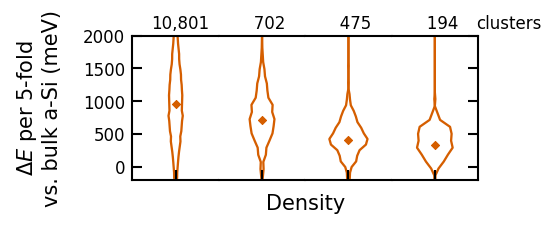

In [9]:
f2, a2, means = plot_production_surface(graph_1M, a1M_11Ks_g18_es_bulk, ulim=2000, included_nodes=[3, 5, 14, 24, 34], ng=4)

# Compare clustering to idealised random distributions

first we reassign a random selection of atoms as 'special' in the original a-Si structure and recalculate the clustering

In [10]:
a1M_ase = read(a1M_11Ks_file)

In [11]:
import random
random.seed(42)
rand_inds = [random.sample(range(0, len(a1M_ase)), 16809) for i in range(5)]

In [12]:
a1M_ase.arrays['c_cn_true'] = a1M_ase.arrays['Coordination']
a1M_ase.arrays['c_pe_at'] = np.zeros(len(a1M_ase))


In [14]:
graphs_relabel_a1M = []
for i in range(5):
    a1M_ase.arrays['c_cn'] = np.ones(len(a1M_ase))*4
    a1M_ase.arrays['c_cn'][rand_inds[i]] = 5
    write("tmp/relabel_a1M.xyz", a1M_ase)
    graphs_relabel_a1M.append(DefectGraph("tmp/relabel_a1M.xyz",
                                medium=[14, 24, 34],
                                bulk_level=0,
                                recalc_cn=False))

Preparing structure files... done. Structure has 16809 atoms
setting types...Type summary:  (array([5]), array([16809]))
 done
Found connected components:  16256
Found 16256 subgraphs
Medium is  [14, 24, 34]
Searching recursively for neighbouring medium
Linking nodes with max separation  0
found 0 extra links due to non-zero max separation
Length of tmp_Gs 16256
Categorising 16256 subgraphs
Summary: 

[5]                                                    15728
[5, 5]                                                 503
[5, 5, 5]                                              24
[5, 5, 5]                                              1
[5, 5, 5]                                              1
Preparing structure files... done. Structure has 16809 atoms
setting types...Type summary:  (array([5]), array([16809]))
 done
Found connected components:  16154
Found 16154 subgraphs
Medium is  [14, 24, 34]
Searching recursively for neighbouring medium
Linking nodes with max separation  0
found 0 extr

next we use a perfect diamond lattice as the base graph on which to label atoms as special

In [15]:
big_dia = bulk('Si', cubic=True)*(50,50,50)
len(big_dia)

1000000

In [16]:
rand_inds = [random.sample(range(0, len(big_dia)), 16809) for i in range(5)]

In [17]:
big_dia.arrays['c_cn'] = np.ones(len(big_dia))*4
big_dia.arrays['c_pe_at'] = np.zeros(len(big_dia))
big_dia.arrays['c_cn'][rand_inds] = 5

In [18]:
graphs_dia = []
for i in range(5):
    big_dia.arrays['c_cn'] = np.ones(len(big_dia))*4
    big_dia.arrays['c_pe_at'] = np.zeros(len(big_dia))
    big_dia.arrays['c_cn'][rand_inds[i]] = 5
    write("tmp/big_dia_rand4.xyz", big_dia)
    graphs_dia.append(DefectGraph('tmp/big_dia_rand4.xyz', medium=[14, 24, 34],
                                  bulk_level=0,
                                  recalc_cn=False))

Preparing structure files... done. Structure has 16809 atoms
setting types...Type summary:  (array([5]), array([16809]))
 done
Found connected components:  16235
Found 16235 subgraphs
Medium is  [14, 24, 34]
Searching recursively for neighbouring medium
Linking nodes with max separation  0
found 0 extra links due to non-zero max separation
Length of tmp_Gs 16235
Categorising 16235 subgraphs
Summary: 

[5]                                                    15685
[5, 5]                                                 528
[5, 5, 5]                                              20
[5, 5, 5, 5]                                           2
[5, 5, 5, 5]                                           2
Preparing structure files... done. Structure has 16809 atoms
setting types...Type summary:  (array([5]), array([16809]))
 done
Found connected components:  16269
Found 16269 subgraphs
Medium is  [14, 24, 34]
Searching recursively for neighbouring medium
Linking nodes with max separation  0
found 0 extr

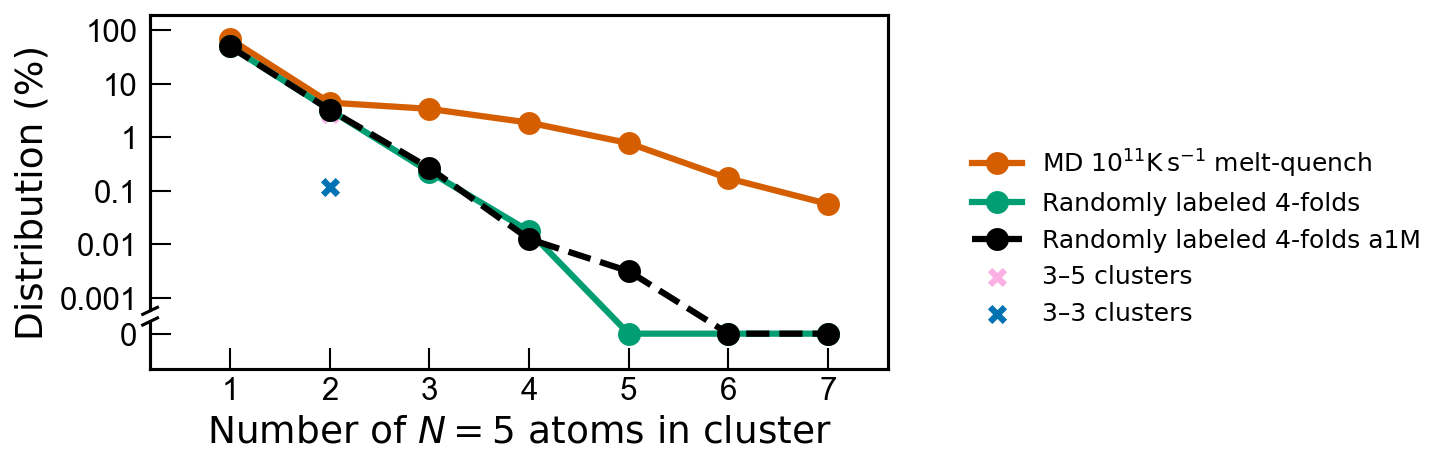

In [19]:
fig = plt.figure(figsize=np.array([4.0, 1.6])*1.92, dpi=150)
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 0.1])
axs = plt.subplot(gs[0])
s = graph_1M
lab = 11
cs = sns.color_palette('colorblind')
cmap = sns.color_palette('flare', as_cmap=True)

h, b = np.histogram(s.clus5, bins=np.arange(1,9))
total_def = np.sum(s.clus5)
h = h.astype(np.float64)
h *= (100/total_def)  # proportion of clusters
axs.plot(b[:-1], h, c=cs[3], marker='o',
         label='MD $\mathrm{10^{11} K\,s^{-1}}$ melt-quench', markersize=10)


h2, b2 = np.histogram(flatten([i.clus5 for i in graphs_dia]),
                      bins=np.arange(1,9))
h2 = h2.astype(np.float64)/10
h2 *= (100*b2[:-1]/total_def)
axs.plot(b2[:-1], h2, marker='o', c=cs[2],
         label='Randomly labeled 4-folds', markersize=10)

h3, b3 = np.histogram(flatten([i.clus5 for i in graphs_relabel_a1M]),
                      bins=np.arange(1,9))
h3 = h3.astype(np.float64)/10
h3 *= (100*b3[:-1]/total_def)
axs.plot(b3[:-1], h3, marker='o', color='k',
         label='Randomly labeled 4-folds a1M', markersize=10, ls='--')

axs.scatter([2], [100*435/total_def], marker='x',
            color=cs[6], s=50, label='3–5 clusters')
axs.scatter([2], [100*19/total_def], marker='x',
            color=cs[0], s=50, label='3–3 clusters')

# just plotting niceties from here
axs.set(xticks=np.arange(1,9))
axs.set_xlim(0.2, 7.6)
axs.set(xlabel='Number of $N=5$ atoms in cluster')
axs.set(ylabel='Distribution (%)')
axs.set_yscale('symlog', linthresh=0.001, linscale=0.6)
formatter = mpl.ticker.PercentFormatter(symbol="", decimals=2)
axs.get_yaxis().set_major_formatter(formatter)
labels = []
ticks = [0, 0.001, 0.01, 0.1, 1.0, 10, 100]
for tick in ticks:
    label = f'{tick:0<6.3f}'
    if label[0] == '1':
        label = label.split('.')[0]
    elif label.rstrip('0') == '0.':
        label = '0'
    else:
        label = label.rstrip('0')
        
    labels.append(label)
axs.set_yticks(ticks)
axs.set_yticklabels(labels)
axs.set_yticks([], minor=True)
axs.set(ylim=(-0.001, 195))
axs.legend(frameon=False, loc = 'lower left', bbox_to_anchor=(1.05, -0.01))

# make the scale-break lines
d = .01 # how big to make the diagonal lines in axes coordinates
slw = axs.spines['left'].get_linewidth()
sep = 0.03
pos = 0.15
kwargs = dict(transform=axs.transAxes, color='k', clip_on=False, lw=slw)
axs.spines['left'].set_visible(False)
axs.plot((0-d, 0+d), (pos+sep/2-d, pos+sep/2+d), **kwargs)
axs.plot((0-d, 0+d), (pos-sep/2-d, pos-sep/2+d), **kwargs)
axs.plot((0,0), (0, pos-sep/2*1.15), **kwargs)
axs.plot((0,0), (pos+sep/2*1.15, 1.0), **kwargs)
plt.yticks(fontname = "Arial")
plt.xticks(fontname = "Arial")
axs.yaxis.set_tick_params(pad=6)
fig.set_facecolor('w')